In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from scipy.stats import kurtosis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA

In [2]:
SEED = 77

# preprocessing: scaling the data and split dataset
data = pd.read_csv("../winequality.csv")
predictors = data[data.columns.difference(["label"])]
scaler = MinMaxScaler()
predictors_scaled = scaler.fit_transform(predictors)
target = data[["label"]].values.ravel()

train_X, test_X, train_y, test_y = train_test_split(predictors_scaled, target, train_size=0.8, random_state=SEED, stratify=target)

# in clustering experiments, only use training set
data, label = train_X, train_y

In [3]:
reconstructionErrors = []
averageKurtosis = []

maxComponents = 11
minComponents = 1
for i in range(minComponents, maxComponents+1):
    ica = FastICA(n_components=i, random_state=SEED)
    data_transform = ica.fit_transform(data)
    data_inverse = ica.inverse_transform(data_transform)
    mse = np.sum(np.square(data - data_inverse))/data_inverse.size
    
    reconstructionErrors.append(mse)
    averageKurtosis.append(np.average(kurtosis(ica.components_)))

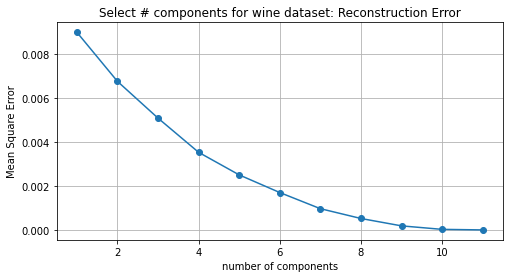

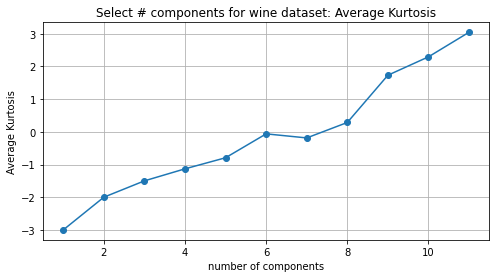

In [4]:
plt.figure(figsize=(8,4))
plt.plot(range(minComponents, maxComponents+1), reconstructionErrors,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('Mean Square Error')
plt.title('Select # components for wine dataset: Reconstruction Error')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\ica_wine_error.png', dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(minComponents, maxComponents+1), averageKurtosis,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('Average Kurtosis')
plt.title('Select # components for wine dataset: Average Kurtosis')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\ica_wine_kurtosis.png', dpi=300)
plt.show()

Misclassified samples: 190
SVM Kernel train/test accuracy: 0.725/0.729


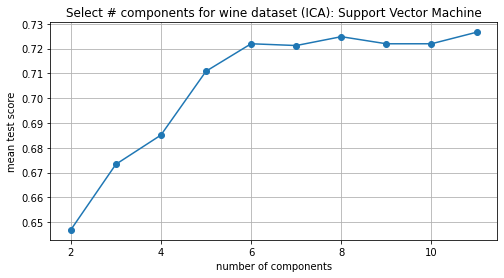

In [5]:
from sklearn.decomposition import FastICA
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

######
# Run Grid Search to find optimal components
######
# import packages
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

SEED = 77
# preprocessing: scaling the data and split dataset
data = pd.read_csv("../winequality.csv")
predictors = data[data.columns.difference(["label"])]

target = data[["label"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.8, random_state=SEED, stratify=target)
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_toTransform = X_train_std
y_train = y_train
y_test = y_test

# Define the classifier
svm = SVC(random_state=1, kernel='linear', gamma=0.1, C=10)
pipe = Pipeline([
    ('reduce_dim', FastICA())
     ,('classify', svm)
])
N_FEATURES_OPTIONS = range(2,12)
parameters = {  'reduce_dim__n_components':N_FEATURES_OPTIONS,
             }
clf = GridSearchCV(pipe, cv=5, param_grid=parameters, n_jobs=-1)

# Run the classifier
clf.fit(X_train_std, y_train)

# Identify training and test accuracy
y_pred = clf.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('SVM Kernel train/test accuracy: %.3f/%.3f' % (train_accuracy, test_accuracy))

mean_scores = np.array(clf.cv_results_['mean_test_score'])

mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (1 + 1) + .5)

scores = [x for x in clf.cv_results_['mean_test_score']]

plt.figure(figsize=(8,4))
plt.plot(N_FEATURES_OPTIONS, scores,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('mean test score')
plt.title('Select # components for wine dataset (ICA): Support Vector Machine')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\ica_wine_svm.png', dpi=300)
plt.show()